# Introduction

This notebook is a collection of examples that illustrate how to use PySpark with MLlib. This whole collection of examples is intended to be a gentle introduction to those interested in the topic, want to have additional examples, or simply are curious about how to start with this library.

The following skills are expected to follow these examples:
- Python
- Understanding Spark structures (Dataframes, RDD)
- Basic ML notions. This is not intended to be a ML course although, you can find some theoretical explanations.

The examples are designed to work with a simple local environment using the MLlib Dataframe. The MLlib RDD-based API is now in maintenance ([see here](https://spark.apache.org/docs/latest/ml-guide.html#announcement-dataframe-based-api-is-primary-api)). This is why you will see that the main import statement comes from `pyspark.ml` not `pyspark.mllib`.

You will need a spark environment to be available in your local path. Refer [here](https://spark.apache.org/docs/latest/api/python/getting_started/install.html) to the official guide for more details. 

You will need java to be available on your local path. Check it out running `java --version`. If nothing is displayed, check out how to install Java on your machine ([here](https://www.oracle.com/java/technologies/downloads/)). Next, you can easily set up a local environment and install the dependencies used in this notebook.

```bash
virtualenv env
source env/bin/activate
pip install urllib3 numpy matplotlib pyspark
```

Wait until the dependencies are already satisfied. If you are not reading these lines from a Jupyter Notebook :) install and run it.

```bash
pip install jupyter
jupyter-notebook
```

# Data types

Spark Dataframes support a collection of rows containing elements with different data types. In the context of ML algorithms, data types such as `boolean`, `string` or even `integer` are not the expected input for most ML algorithms. In this sense, MLlib supports data types such as vectors or matrices. 

## Dense Vectors

A dense vector is an array. PySpark uses `numpy` to run algebraical operations.

[Docs](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.linalg.DenseVector.html)

In [1]:
from pyspark.ml.linalg import DenseVector

a = DenseVector([0,1,2,3,4])
b = DenseVector([10,10,10,10,10])

print('Sum: ', a + b)
print('Difference: ', a - b)
print('Multiplication: ', a * 2)
print('Division: ', b / 2)

print('Non-zeros: ', a.nonzero())
print('Squared distance: ', a.squared_distance(b))

Sum:  [10.0,11.0,12.0,13.0,14.0]
Difference:  [-10.0,-9.0,-8.0,-7.0,-6.0]
Multiplication:  [0.0,2.0,4.0,6.0,8.0]
Division:  [5.0,5.0,5.0,5.0,5.0]
Non-zeros:  (array([1, 2, 3, 4]),)
Squared distance:  330.0


## Sparse Vectors

Sparse vectors are designed to represent those vectors where a large number of elements is expected to be zero. These vectors are defined by specifying which positions of the array are different from zero and the assigned values. In 

```python
SparseVector (5 ,[0 ,2 ,4] ,[1 ,3 ,5])
```

we have five elements with entries 0, 2, and 4 take values 1, 3, and 5.

[Docs](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.linalg.SparseVector.html)

In [2]:
from pyspark.ml.linalg import SparseVector

sparse_vector = SparseVector (5 ,[0 ,2 ,4] ,[1 ,3 ,5])
print('Sparse vector: ', sparse_vector.toArray ())
print('Indices: ', sparse_vector.indices )
print('Non zeros: ', sparse_vector.numNonzeros ())

Sparse vector:  [1. 0. 3. 0. 5.]
Indices:  [0 2 4]
Non zeros:  3


# Input/Output

We can expect datasets to be available from different storage sources:

- Hard disks
- HDFS
- Databases
- Others

The `SparkSession` object facilitates the load of data from these sources under different formats (CSV, JSON, text, parquet, databases, etc.). We will show  examples for CSV, libSVM, and images.

## CSV

Let's assume the following dataset in a CSV format:

```csv
label,f1,f2,f3,f4
0,0,"one",2.0,true
1,4,"five",6.0,false
```

We instantiate a `SparkSession` object and load the dataset indicating that we have a header and the separation character.

In [5]:
'''
For this example we need the dataset.csv file to be available. 

Copy and paste the following lines:

echo "\
label,f1,f2,f3,f4
0,0,"one",2.0,true
1,4,"five",6.0,false" > /tmp/dataset.csv

'''

from pyspark.sql import SparkSession

# Get a session object for our current Spark master
session = SparkSession.builder.appName("Example").master("local").getOrCreate()

dataset = session.read.format('csv')\
.option('header', 'true')\
.option('sep', ',')\
.load('/tmp/dataset.csv')

dataset.show()

# we stop the session
session.stop()


+-----+---+----+---+-----+
|label| f1|  f2| f3|   f4|
+-----+---+----+---+-----+
|    0|  0| one|2.0| true|
|    1|  4|five|6.0|false|
+-----+---+----+---+-----+



## libSVM

[LibSVM](www.csie.ntu.edu.tw/~cjlin/libsvm/) is a popular format to represent numeric sparse data. 

The following dataset:

```
0 128:51  129:159
1 130:253 131:159  132:50
1 155:48  156:238

```

Where the first row `0 128:51 129:159` indicates an observation with label 0 and feature $128^{th}$ and $129^{th}$ equal to $51$ and $159$ respectively. We can load this dataset using the `SparkSession` object as we did for the `CSV` format.

In [6]:
'''
For this example we need the dataset.libsvm file to be available. 

Copy and paste the following lines:

echo "\
0 128:51  129:159
1 130:253 131:159  132:50
1 155:48  156:238" > /tmp/dataset.libsvm

'''

from pyspark.sql import SparkSession

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

dataset = session.read.format('libsvm').option('numFeatures',157).load('/tmp/dataset.libsvm')

dataset.show()
                              
# we stop the session
session.stop()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(157,[127,128],[5...|
|  1.0|(157,[129,130,131...|
|  1.0|(157,[154,155],[4...|
+-----+--------------------+



## Images

LMlib can load images in variety of formats (jpeg, png, etc.). It also supports compressed formats. The resulting DataFrame has a column `image` containing information of the schema.

More details in the [docs](https://spark.apache.org/docs/latest/ml-datasource.html#image-data-source)

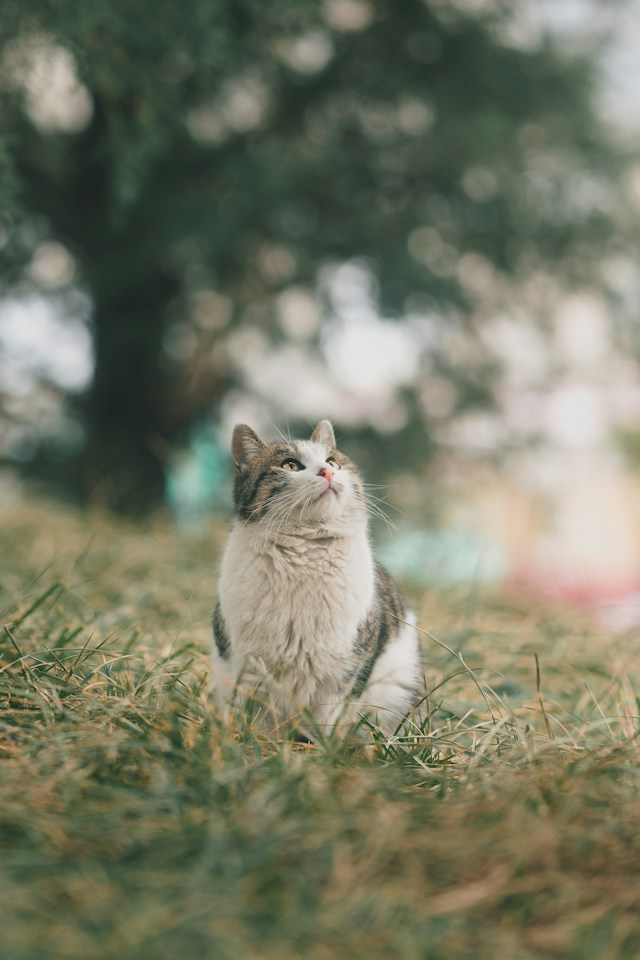

In [7]:
# We download a cat image for later

import urllib3
import tempfile
from IPython.display import Image
import sys

url='https://unsplash.com/photos/ECfPmkOVZPA/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzA2MDA3NDAyfA&force=true&w=640'
cat_image = tempfile.gettempdir() + '/kitty.png'

http = urllib3.PoolManager()
r = http.request('GET', url, preload_content=False)
    
with open(cat_image, 'wb') as f:
    while True:
        data = r.read()
        if not data:
            break
        f.write(data)
r.release_conn()

Image(filename=cat_image)     


In [8]:
from pyspark.sql import SparkSession

session = SparkSession.builder.appName('Example').master('local').getOrCreate()
df = session.read.format('image').option('dropInvalid', True).load(cat_image)

df.select('image.origin', 'image.width', 'image.height', 'image.nChannels', 'image.mode').show(truncate=False)

# The image data is stored in the image.data column, one image per row.
img_data = df.select('image.data').collect()[0]

# Do something with img_data...

session.stop()

+---------------------+-----+------+---------+----+
|origin               |width|height|nChannels|mode|
+---------------------+-----+------+---------+----+
|file:///tmp/kitty.png|640  |960   |3        |16  |
+---------------------+-----+------+---------+----+



# Features

One of the main tasks for any data engineer is data preparation. For two reasons:

1. Raw data is not ready to be consumed by algorithms
2. Preprocessing data is required to improve algorithms performance

Incoming data has to be processed in different steps until we reach a successful representation to be consumed by algorithms. MLlib offers a collection of feature-related operations. We can distinguish:

- Extraction: extract features from raw data
- Transformation: modifying/converting features
- Selection: select features based on a certain criteria
- [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) (LSH): algorithms combining feature transformation with other algorithms

In general feature processing in MLlib follows these steps:

1. **Instantiate** the operator indicating the name of the input and output columns and additional params.
2. **Fit the model** invoking the `.fit(...)` method to train a model. Some operators may not require this step if they are not associated with a model.
3. **Transform** the input data using the model

No need to mention that these steps, the input params, and the input format vary from operator to operator.

The following sections present succint examples of different operators.



## Normal standardization

Scale a feature to obtain a normal distribution with mean 0 and unit-variance.

$x'_i = \dfrac{x_i-\mu}{\sigma}$

Where
- $x_i$ is the feature value
- $\mu$ is the mean of the distribution and $\sigma$ is the standard deviation
- $x'_i$ becomes the standardized feature

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

values = [[0, Vectors .dense ([1.0,0.1, -1.0])],
          [1, Vectors .dense ([2.0 ,1.1 ,1.0])] ,
          [2, Vectors .dense ([3.0 ,10.1 ,3.0])]]
dataset = session.createDataFrame(values, ['id', 'features'])
dataset.show()

+---+--------------+
| id|      features|
+---+--------------+
|  0|[1.0,0.1,-1.0]|
|  1| [2.0,1.1,1.0]|
|  2|[3.0,10.1,3.0]|
+---+--------------+



In [10]:
# Fit
scaler = StandardScaler(inputCol = 'features', outputCol='standardized', withMean=True, withStd=True)
scalerModel = scaler.fit(dataset)

# Print some statistics
print("Mean is: %s with sd: %s" % (scalerModel.mean, scalerModel.std))

# Transform
standardized = scalerModel.transform(dataset)
standardized.show()

Mean is: [2.0,3.7666666666666666,1.0] with sd: [1.0,5.507570547286102,2.0]
+---+--------------+--------------------+
| id|      features|        standardized|
+---+--------------+--------------------+
|  0|[1.0,0.1,-1.0]|[-1.0,-0.66575028...|
|  1| [2.0,1.1,1.0]|[0.0,-0.484182026...|
|  2|[3.0,10.1,3.0]|[1.0,1.1499323120...|
+---+--------------+--------------------+



We can check if the transformed data has the desired distribution using a `Summarizer` ([docs here](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.stat.Summarizer.html?highlight=mean#pyspark.ml.stat.Summarizer)). For every feature we have mean set to 0 and standard deviation equal to 1. 

In [11]:
# Let's see what are the mean and the std now
from pyspark.ml.stat import Summarizer
summarizer = Summarizer.metrics("mean", "std")
standardized.select(summarizer.summary(standardized.standardized)).show(truncate=False)

session.stop()

+---------------------------------------------+
|aggregate_metrics(standardized, 1.0)         |
+---------------------------------------------+
|{[0.0,0.0,0.0], [1.0,0.9999999999999999,1.0]}|
+---------------------------------------------+



## Elementwise product

This transformer multiplies each input vector by a provided vector, using element-wise multiplication. This operation scales each column by a given scalar ([Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29)). For example:

$$
\begin{bmatrix}
    2 & 3 & 1 \\
    0 & 8 & -2
  \end{bmatrix} \circ \begin{bmatrix}
    3 & 1 & 4
  \end{bmatrix} = \begin{bmatrix}
    2 \times 3 & 3 \times 1 & 1 \times 4 \\
    0 \times 3 & 8 \times 1 & -2 \times 4
  \end{bmatrix} = \begin{bmatrix}
    6 & 3 & 4 \\
    0 & 8 & -8
  \end{bmatrix}
$$

In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import ElementwiseProduct

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

a = [[Vectors.dense ([2,3,1])],
     [Vectors.dense ([0,8,-2])]]

b = Vectors.dense ([3,1,4])
print('b =',b)

df_a = session.createDataFrame(a, ['features'])
df_a.show()

ewp = ElementwiseProduct(inputCol='features', outputCol='product', scalingVec=b)

a_b = ewp.transform(df_a)
a_b.show()


b = [3.0,1.0,4.0]


+--------------+
|      features|
+--------------+
| [2.0,3.0,1.0]|
|[0.0,8.0,-2.0]|
+--------------+

+--------------+--------------+
|      features|       product|
+--------------+--------------+
| [2.0,3.0,1.0]| [6.0,3.0,4.0]|
|[0.0,8.0,-2.0]|[0.0,8.0,-8.0]|
+--------------+--------------+



## Principal Component Analysis

When dealing with many features we can come across the **curse of dimensionality**.
- More than three variables are difficult to plot
- Performance issues for a large number of features
- Features that only add "noise" to the problem
- Algorithms may find difficult to converge to a solution

Principal Component Analysis (PCA) is a dimensionality reduction technique that aims to find the components that maximize the variance. These are the steps to follow:

- Standardize the data
- Compute eigenvectors and eigenvalues of the covariance matrix
- Sort eigenvalues and pick the $d$ larges values
- Construct matrix $\mathbf{W}$ using the $d$ corresponding eigenvectors
- Transform dataset $\mathbf{X}$ multiplying it by $\mathbf{W}$

The covariance matrix is a symmetric matrix with the covariance between variables. It looks like this

$$
\mathrm{cov}(X_i, X_j) = \mathrm{E}\begin{bmatrix}
(X_i - \mu_i)(X_j - \mu_j)
\end{bmatrix} = \mathrm{E}\begin{bmatrix}X_iX_j
\end{bmatrix} - \mu_i\mu_j
$$

$$
\mathrm{cov}(\mathbf{X},\mathbf{Y})= \begin{bmatrix}
 \mathrm{cov}(X_1,Y_1) & \mathrm{cov}(X_1,Y_2) & \cdots & \mathrm{cov}(X_1,Y_n) \\ \\
 \mathrm{cov}(X_2,Y_1) & \mathrm{cov}(X_2,Y_2) & \cdots & \mathrm{cov}(X_2,Y_n) \\ \\
 \vdots & \vdots & \ddots & \vdots \\ \\
\mathrm{cov}(X_n,Y_1) & \mathrm{cov}(X_n,Y_2) & \cdots & \mathrm{cov}(X_n,Y_n) \\ \\
\end{bmatrix}
$$

In MLlib there is a PCA transformer that implements all these steps. By applying the PCA we can obtain a reduced version of the original that maintains most of the relevant information brought by the features. 

In the example below, we compute the PCA for a dataset of 5 features we wish to convert in a new 3 features dataset.

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

data = [[Vectors.dense ([1.0 , 0.0, 3.0, 0.0, 7.0])],
        [Vectors .dense ([2.0 , 0.0, 3.0, 4.0, 5.0])],
        [Vectors .dense ([4.0 , 0.0, 0.0, 6.0, 7.0])]]

dataset = session.createDataFrame(data, ['features'])
dataset.show()

+--------------------+
|            features|
+--------------------+
|[1.0,0.0,3.0,0.0,...|
|[2.0,0.0,3.0,4.0,...|
|[4.0,0.0,0.0,6.0,...|
+--------------------+



In [14]:
# Fit PCA
pca = PCA(inputCol='features', outputCol='pcaFeatures', k=3)
pcaModel = pca.fit(dataset)

print("The variance for every new feature %s" % pcaModel.explainedVariance)

24/01/25 11:45:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


The variance for every new feature [0.84375,0.15625000000000008,4.509331675237028e-17]


In [15]:
# Transform the original dataset
pcaDataset = pcaModel.transform(dataset)
pcaDataset.show(truncate=False)

+---------------------+---------------------------------------------------------+
|features             |pcaFeatures                                              |
+---------------------+---------------------------------------------------------+
|[1.0,0.0,3.0,0.0,7.0]|[0.8164965809277265,3.65148371670111,-2.5144734900027204]|
|[2.0,0.0,3.0,4.0,5.0]|[-2.857738033247042,0.9128709291752779,-2.51447349000272]|
|[4.0,0.0,0.0,6.0,7.0]|[-6.53197264742181,3.6514837167011094,-2.514473490002719]|
+---------------------+---------------------------------------------------------+



Observe that the transformed dataset does no longer correspond to any real observation. Any model predictions generated using this transformed data for training, has to be reconstructed. Otherwise, the output will no make any sense.

## StringIndexer

This is a label indexer that assigns a label to every string in a column. If the value is numeric, first it is casted to string and then indexed.

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

data = session.createDataFrame([['blue'], ['red'],
                                ['red'], ['white'],
                                ['yellow'], ['red']], ['feature'])
data.show()

si = StringIndexer(inputCol='feature', outputCol='index', )
model = si.fit(data)
print('Found labels: ', model.labels)
model.transform(data).show()

session.stop()

+-------+
|feature|
+-------+
|   blue|
|    red|
|    red|
|  white|
| yellow|
|    red|
+-------+

Found labels:  ['red', 'blue', 'white', 'yellow']
+-------+-----+
|feature|index|
+-------+-----+
|   blue|  1.0|
|    red|  0.0|
|    red|  0.0|
|  white|  2.0|
| yellow|  3.0|
|    red|  0.0|
+-------+-----+



## One hot encoder

This encoder maps a column of indices into a single binary vector. If we have 4 labels, for index 3 we will have $[0,0,0,1,0]$. The output is a `SparseVector`.

Observe that the param `dropLast` is `True` by default ignoring the label with index $n-1$. 

In [17]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, OneHotEncoder

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

data = session.createDataFrame([['blue'], ['red'],
                                ['red'], ['white'],
                                ['yellow'], ['red']], ['feature'])
data.show()

# First we need an input column with indices instead of strings.
si = StringIndexer(inputCol='feature', outputCol='indexed')
si_model = si.fit(data)
indexed = si_model.transform(data)
indexed.show()

# If we let dropLast=True, the index for yellow will be dropped
ohe = OneHotEncoder(inputCol='indexed', outputCol='encoded', dropLast=False)
ohe_model = ohe.fit(indexed)
ohe_transformed = ohe_model.transform(indexed)

'''
You can check how setting dropLast=True, the 4th row will be

+-------+-------+-------------+
|feature|indexed|      encoded|
+-------+-------+-------------+
| yellow|    3.0|(3,[],[])    |
+-------+-------+-------------+
'''
ohe_transformed.show()



[Stage 0:>                                                          (0 + 1) / 1]



+-------+
|feature|
+-------+
|   blue|
|    red|
|    red|
|  white|
| yellow|
|    red|
+-------+

+-------+-------+
|feature|indexed|
+-------+-------+
|   blue|    1.0|
|    red|    0.0|
|    red|    0.0|
|  white|    2.0|
| yellow|    3.0|
|    red|    0.0|
+-------+-------+

+-------+-------+-------------+
|feature|indexed|      encoded|
+-------+-------+-------------+
|   blue|    1.0|(4,[1],[1.0])|
|    red|    0.0|(4,[0],[1.0])|
|    red|    0.0|(4,[0],[1.0])|
|  white|    2.0|(4,[2],[1.0])|
| yellow|    3.0|(4,[3],[1.0])|
|    red|    0.0|(4,[0],[1.0])|
+-------+-------+-------------+



## Tokenization

Tokenization is the process of splitting a document into a vector of differentiated tokens. The sentence `"The quick brown fox jumps over the lazy dog"` will be split into tokens like in `["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]`. Different approaches may split the document using white spaces, commas, regular expressions, or any other character.

In MLlib there is a Tokenizer transformer for this purpose.

In [18]:
from pyspark .sql import SparkSession
from pyspark .ml. feature import Tokenizer

session = SparkSession.builder.appName("Example").master("local").getOrCreate()
sentenceDataFrame = session.createDataFrame ([(0, "Hi I heard about Spark"),
                                            (1, "I wish Java could use case classes"),
                                            (2, "Logistic, regression, models, are, neat")], ['id', 'sentence'])

tokenizer = Tokenizer(inputCol='sentence', outputCol='words')
tokenizer.transform(sentenceDataFrame).show(truncate=False)

+---+---------------------------------------+---------------------------------------------+
|id |sentence                               |words                                        |
+---+---------------------------------------+---------------------------------------------+
|0  |Hi I heard about Spark                 |[hi, i, heard, about, spark]                 |
|1  |I wish Java could use case classes     |[i, wish, java, could, use, case, classes]   |
|2  |Logistic, regression, models, are, neat|[logistic,, regression,, models,, are,, neat]|
+---+---------------------------------------+---------------------------------------------+



## Stop words

Natural language is redundant and not every term provides the same amount of information. By stop words we refer to the most common words in a given language. These words are so common that result into non-relevant chunks of information. These words are removed previously to any analysis. There is no a single list of stop words and this changes with every language. 

MLlib implements the [`StopWordsRemover`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html#stopwordsremover)  that filters out stop words using a dictionary.

In [19]:
from pyspark .sql import SparkSession
from pyspark .ml. feature import StopWordsRemover

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

text = session.createDataFrame ([(0, ["I", "saw", "the", "red", " balloon "]),
                                (1, ["Mary", "had", "a", " little ", "lamb"])
                                ], ["id", "raw"])
text.show(truncate=False)

remover = StopWordsRemover(inputCol='raw', outputCol='filtered')
remover.transform(text).show(truncate=False)

+---+------------------------------+
|id |raw                           |
+---+------------------------------+
|0  |[I, saw, the, red,  balloon ] |
|1  |[Mary, had, a,  little , lamb]|
+---+------------------------------+

+---+------------------------------+----------------------+
|id |raw                           |filtered              |
+---+------------------------------+----------------------+
|0  |[I, saw, the, red,  balloon ] |[saw, red,  balloon ] |
|1  |[Mary, had, a,  little , lamb]|[Mary,  little , lamb]|
+---+------------------------------+----------------------+



## Count Vectorizer

This estimator counts the number of occurrences of items in a vocabulary represented in a sparse vector. This is particularly useful to represent a document in terms of the frequency of its elements and it is normally used in probabilistic models.

In [20]:
from pyspark .sql import SparkSession
from pyspark.ml.feature import CountVectorizer

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

text = session.createDataFrame ([(0,'yellow red blue'.split()),
                                (1, 'red'.split()),
                                (2, 'blue white blue'.split()),
                                ], ["id", "raw"])

text.show()

cv = CountVectorizer(inputCol='raw', outputCol='frequencies')
cv_model = cv.fit(text)
print('The vocabulary: ',cv_model.vocabulary)
frequencies = cv_model.transform(text)
frequencies.show(truncate=False)

+---+-------------------+
| id|                raw|
+---+-------------------+
|  0|[yellow, red, blue]|
|  1|              [red]|
|  2|[blue, white, blue]|
+---+-------------------+

The vocabulary:  ['blue', 'red', 'white', 'yellow']
+---+-------------------+-------------------------+
|id |raw                |frequencies              |
+---+-------------------+-------------------------+
|0  |[yellow, red, blue]|(4,[0,1,3],[1.0,1.0,1.0])|
|1  |[red]              |(4,[1],[1.0])            |
|2  |[blue, white, blue]|(4,[0,2],[2.0,1.0])      |
+---+-------------------+-------------------------+



## N-grams

N-grams are a common input for many algorithms to understand the probability of $n$ words to occur together. The `NGram` transformer outputs a collection of these N-grams.

In [22]:
from pyspark .sql import SparkSession
from pyspark.ml.feature import IDF, Tokenizer, NGram

session = SparkSession.builder.appName("Example").master("local").getOrCreate()


text = session.createDataFrame ([(0, "Hi I heard about Spark"),
                                (0, "I wish Java could use case classes "),
                                (0, "Logistic regression models are neat")
                                ], ["label", "sentence"])

# First we tokenize our dataset
tokenizer = Tokenizer(inputCol ='sentence', outputCol ='words')
words = tokenizer.transform(text)
words.show(truncate=False)

# Compute 2-grams
ngram = NGram(inputCol='words', outputCol='ngrams', n=2)
ngrams = ngram.transform(words)
ngrams.show(truncate=False)

+-----+-----------------------------------+------------------------------------------+
|label|sentence                           |words                                     |
+-----+-----------------------------------+------------------------------------------+
|0    |Hi I heard about Spark             |[hi, i, heard, about, spark]              |
|0    |I wish Java could use case classes |[i, wish, java, could, use, case, classes]|
|0    |Logistic regression models are neat|[logistic, regression, models, are, neat] |
+-----+-----------------------------------+------------------------------------------+

+-----+-----------------------------------+------------------------------------------+------------------------------------------------------------------+
|label|sentence                           |words                                     |ngrams                                                            |
+-----+-----------------------------------+---------------------------------------

## TF-IDF

Computing the number of occurrences of a term in a document or a collection of documents we can weight its relevance ([here](http://en.wikipedia.org/wiki/Tf%E2%80%93idf).

- **Term-frequency (tf)**: the ratio of occurrences of a term in a document among the total

$$
tf(t,d) = \dfrac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}
$$


- **Inverse document frequency (idf)**: measure of how much information the term provides

$$
idf(t,d) = \log \dfrac{|D|}{|d \in D : t \in d |} 
$$

Let's assume a corpus of documents $D$ with two documents $d_1$ and $d_2$. With the terms and their frequencies shown below:

Document $d_1$

|term|frequency|
|----|---------|
|this|1|
|is|1|
|a|2|
|sample|1|


Document $d_2$

|term|frequency|
|----|---------|
|this|1|
|is|1|
|another|2|
|sample|3|


If we want to understand the relevance of *this* in $d_1$ we can compute the tf and idf.

$$tf(this,d_1)=\dfrac{1}{5}$$

The word *this* appears only one in $d_1$ from the total of $5$ terms (sum of all the frequencies).

$$idf(this, D) = log\dfrac{2}{2}=0$$

With the idf we can get how relevant is *this* in the corpus $D$. It appears in both documents, therefore it does not bring too much information.

If we compute the same for *another* we can see the word is more relevant as it appears with a higher frequency but not in all the documents of the corpus $D$.

$$tf(another,d_2)=\dfrac{2}{7}$$

$$idf(another, D) = log\dfrac{2}{1}=0.69$$

We can combine both metrics using the **tfidf** to filter out common terms and highlight relevant terms:

$$
\mathbf{tfidf}(t,d,D)=\mathbf{tf}(t,d) \cdot\mathbf{idf}(t,D)
$$

With **tfidf** we can weight how relevant is a term inside a document considering how frequently it is found. For the previous example:

$$
\mathbf{tfidf}(\text{this},d1,D)=\dfrac{1}{5} \cdot 0
$$

$$
\mathbf{tfidf}(\text{this},d1,D)=\dfrac{1}{5} \cdot 0
$$

In a practical scenario we will use vectorized versions. For a vocabulary {a,b,c} and three documents:

|Input|TF-vector|
|-----|---------|
|{a,b,c} | {1,1,1} |
|{a,b,c,c,a} | {2,2,1}|
|{a,a,a,c,a} | {4,0,1}|

Usually the vocabulary is trimmed by discarded terms with a small idf to avoid non-relevant terms. This can be done using the params `mindf` and `mintf` from the `CountVectorizer` transformer. Take a look at the [Bag of words](#Bag-of-words) section. 

The following example computes the idf of a corpus using the `IDF` transformer.

In [23]:
from pyspark.ml.feature import IDF, Tokenizer, CountVectorizer

corpus = session.createDataFrame ([
                                (0.0, "Java has been around for a while"),
                                (0.0, "I wish Java could use case classes"),
                                (0.0, "Objects belong to classes")
                                ], ["label", "sentence"])

# First, get the tokens
tokenizer = Tokenizer(inputCol ='sentence', outputCol ='tokens')
tokens = tokenizer.transform(corpus)
tokens.show(truncate=False)

+-----+----------------------------------+------------------------------------------+
|label|sentence                          |tokens                                    |
+-----+----------------------------------+------------------------------------------+
|0.0  |Java has been around for a while  |[java, has, been, around, for, a, while]  |
|0.0  |I wish Java could use case classes|[i, wish, java, could, use, case, classes]|
|0.0  |Objects belong to classes         |[objects, belong, to, classes]            |
+-----+----------------------------------+------------------------------------------+



In [24]:
# Second, compute the frequency of every token. We could remove stop words here.
# We are going to reduce the corpus to a vocabulary of two words for those tokens appearing at least twice in the corpus.
vectorizer = CountVectorizer(inputCol='tokens', outputCol='frequencies', minDF=2.0, vocabSize=2)
model = vectorizer.fit(tokens)
print("This is our vocabulary %s" % model.vocabulary)
frequencies = model.transform(tokens)
frequencies.show()

This is our vocabulary ['classes', 'java']
+-----+--------------------+--------------------+-------------------+
|label|            sentence|              tokens|        frequencies|
+-----+--------------------+--------------------+-------------------+
|  0.0|Java has been aro...|[java, has, been,...|      (2,[1],[1.0])|
|  0.0|I wish Java could...|[i, wish, java, c...|(2,[0,1],[1.0,1.0])|
|  0.0|Objects belong to...|[objects, belong,...|      (2,[0],[1.0])|
+-----+--------------------+--------------------+-------------------+



In [25]:
# Third, we compute the IDF
idf = IDF(inputCol='frequencies', outputCol='idf')
idf_model = idf.fit(frequencies)
idf_result = idf_model.transform(frequencies)
idf_result.show(truncate=False)

+-----+----------------------------------+------------------------------------------+-------------------+---------------------------------------------------+
|label|sentence                          |tokens                                    |frequencies        |idf                                                |
+-----+----------------------------------+------------------------------------------+-------------------+---------------------------------------------------+
|0.0  |Java has been around for a while  |[java, has, been, around, for, a, while]  |(2,[1],[1.0])      |(2,[1],[0.28768207245178085])                      |
|0.0  |I wish Java could use case classes|[i, wish, java, could, use, case, classes]|(2,[0,1],[1.0,1.0])|(2,[0,1],[0.28768207245178085,0.28768207245178085])|
|0.0  |Objects belong to classes         |[objects, belong, to, classes]            |(2,[0],[1.0])      |(2,[0],[0.28768207245178085])                      |
+-----+----------------------------------+----------

## Word2Vec

The Word2Vec represents the words of a document in a vector. This makes possible to operate with documents as vectors which makes possible to easily computes distances and enables other algorithms specially in NLP. Take a look at the original Google code [here](https://code.google.com/archive/p/word2vec/)

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

corpus = session.createDataFrame([
    ('Spark is quite useful'.split(),),
    ('I can use Spark with Python'.split(),),
    ('Spark is not so difficult after all'.split(),),
    ], ['words'])

corpus.show(truncate=False)

w2v = Word2Vec(inputCol='words', outputCol='result', vectorSize=3, minCount=0)
w2v_model = w2v.fit(corpus)
vectors = w2v_model.transform(corpus)
vectors.show(truncate=False)


+-------------------------------------------+
|words                                      |
+-------------------------------------------+
|[Spark, is, quite, useful]                 |
|[I, can, use, Spark, with, Python]         |
|[Spark, is, not, so, difficult, after, all]|
+-------------------------------------------+

+-------------------------------------------+------------------------------------------------------------------+
|words                                      |result                                                            |
+-------------------------------------------+------------------------------------------------------------------+
|[Spark, is, quite, useful]                 |[0.08182145655155182,-0.07318692095577717,-0.0631803400174249]    |
|[I, can, use, Spark, with, Python]         |[0.016474373017748196,-1.7273581276337305E-4,-0.04478610997709135]|
|[Spark, is, not, so, difficult, after, all]|[0.019738022836723497,0.029656097292900085,-0.033315843919159045] |

# Pipelines

Most models are computed as a concatenation of operations, each operation transforming the original dataset. For example, normalization -> component analysis -> regression. MLlib uses the concept of pipelines (similinar to the one used in [SciKit](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) to unify the execution of a sequence of steps into a single object. 

The pipeline is defined as a sequence of stages connecting transformers and estimators:

- **Transformer**: receives an input dataframe and returns a transformed version (standardizers)
- **Estimator**: receives an input dataframe and after fitting returns a transformer (linear regression, logistic regression, etc.)

Creating a pipeline is equivalent to set the sequence of stages to be executed.

```python
from pyspark.ml.pipeline import Pipeline
pipeline = Pipeline(stages=[standardizer, pca, lr])
```

Then we fit the model and transform the dataset to get the corresponding results:

```python
model = pipeline.fit(dataset)
model.transform(dataset).show()
```



In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.pipeline import Pipeline

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

corpus = session.createDataFrame([
    ('Spark is quite useful',),
    ('I can use Spark with Python',),
    ('Spark is not so difficult after all',),
    ], ['docs'])

corpus.show(truncate=False)

tokenizer = Tokenizer(inputCol='docs', outputCol='tokens')
stop_remover = StopWordsRemover(inputCol='tokens', outputCol='filtered')
cv = CountVectorizer(inputCol='filtered', outputCol='frequencies')

pipeline = Pipeline(stages=[tokenizer, stop_remover, cv])

fitted = pipeline.fit(corpus)
result = fitted.transform(corpus)
result.show(truncate=False)

for m in fitted.stages:
    print('-->',m.uid)
    print(m.params)



+-----------------------------------+
|docs                               |
+-----------------------------------+
|Spark is quite useful              |
|I can use Spark with Python        |
|Spark is not so difficult after all|
+-----------------------------------+

+-----------------------------------+-------------------------------------------+----------------------+-------------------------+
|docs                               |tokens                                     |filtered              |frequencies              |
+-----------------------------------+-------------------------------------------+----------------------+-------------------------+
|Spark is quite useful              |[spark, is, quite, useful]                 |[spark, quite, useful]|(6,[0,2,3],[1.0,1.0,1.0])|
|I can use Spark with Python        |[i, can, use, spark, with, python]         |[use, spark, python]  |(6,[0,1,5],[1.0,1.0,1.0])|
|Spark is not so difficult after all|[spark, is, not, so, difficult, after, al

# Linear Regression

The Spark MLlib offers a linear regression implementation with $L_1$, $L_2$ and ElasticNet regularization.

```python
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3)
    
```

In a naive example where we have a set of observatios corresponding to the equation $y=2x+3$:

| y | x |
|---|---|
| 7 | 2 |
| 9 | 3 |
| 23 | 10 |

We will train a model based on these observations to predict the output for $x=5$. Obviously, this will be $y=13$ ($y=2\times 5 + 3$).


In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

# our observations
observations = [[7.0 , Vectors.dense ([2.0])] ,
                [9.0 , Vectors.dense ([3.0])] ,
                [23.0 , Vectors.dense ([10.0])]
               ]

# We create a dataset as a DataFrame using a colum for label, and a column for the features.
# Observe that in this case, the features are a single column using a Vector.
dataset = session.createDataFrame(observations, ['label', 'features'])

dataset.show()

print("Train our model...")
lr = LinearRegression()
# Train the model
model = lr.fit(dataset)

+-----+--------+
|label|features|
+-----+--------+
|  7.0|   [2.0]|
|  9.0|   [3.0]|
| 23.0|  [10.0]|
+-----+--------+

Train our model...


24/01/25 11:46:40 WARN Instrumentation: [78acba3e] regParam is zero, which might cause numerical instability and overfitting.


Now that we have trained our model we can investigate how does it look internally.

In [29]:
# Show fitted model
print("These are the weights for our model:")
print("Coefficients: %s" % model.coefficients)
print("Intercept: %s" % model.intercept)

These are the weights for our model:
Coefficients: [1.9999999999999998]
Intercept: 3.000000000000002


Unsurprisingly, we have a coefficient near 2 and the intercept value is 3. We were trying to model a linear function so it was a straight forward case.

We can check how was the training in terms of error, iterations, etc.

In [30]:
# Show the training summary
print("This is the training summary:")
print("Num iterations: %d" % model.summary.totalIterations)
print("Residuals:")
model.summary.residuals.show()
print("RMSE: %f" % model.summary.rootMeanSquaredError)

This is the training summary:
Num iterations: 0
Residuals:
+--------------------+
|           residuals|
+--------------------+
|-1.77635683940025...|
|-1.77635683940025...|
|                 0.0|
+--------------------+

RMSE: 0.000000


Now we are going to predict new outputs. We simply feed the model with dataframes using the same format we used to train it.

In [31]:
# in this case we have the label and the observed feature value
to_predict_items = [[13.0, Vectors.dense([5.0])]]

to_predict = session.createDataFrame(to_predict_items, ['label', 'features'])

predictions = model.transform(to_predict)
predictions.show()


+-----+--------+----------+
|label|features|prediction|
+-----+--------+----------+
| 13.0|   [5.0]|      13.0|
+-----+--------+----------+



Because our model is basically perfect, we have a prediction of 13 which is what we were expecting.

In a more complex scenario, we will need to know how good is our model doing. We can check the error using any of the available error evaluators. In this case, for a linear regression we can use the `RegressionEvaluator`. For our `predictions` this value will be 0 because we committed no mistakes.

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator

ev = RegressionEvaluator(metricName='rmse')

ev.evaluate(predictions)

0.0

# Logistic Regression

The Spark MLLib offers a logicstic regression implementation for binominal and multinomial problems in the classification package (docs [here](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html?highlight=logistic#pyspark.ml.classification.LogisticRegression) for more details.)

The example below trains a binary classifier to identify whether a point is contained inside a circle or not.

| x | y | inside |
|---|---|--------|
|0 |0 | 1 |
|0 |2 | 0 |
|2 |0 | 0 |
|1 |0 | 1 |
|0 |1 | 1 |
|0.3 | 0.87 | 1 |
|1 | -1.3 | 1 |
|0.9 | -1.2 | 1 |


<img src="fig/log_circle.png" width="300"/>

Similarly to what we did with the linear regression, we define our dataset based on the observations to fit our model.

In [33]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

observations = [[1.0, Vectors.dense([0.0 ,0.0])],
                [0.0, Vectors.dense([0.0 ,2.0])],
                [0.0, Vectors.dense([2.0 ,0.0])],
                [1.0, Vectors.dense([1.0 ,0.0])],
                [1.0, Vectors.dense([0.0 ,1.0])],
                [1.0, Vectors.dense([0.3 ,0.87])],
                [0.0, Vectors.dense([1.0, -1.3])],
                [1.0, Vectors.dense([0.9, -1.2])]]

dataset = session.createDataFrame(observations, ['label', 'features'])
dataset.show()

+-----+----------+
|label|  features|
+-----+----------+
|  1.0| [0.0,0.0]|
|  0.0| [0.0,2.0]|
|  0.0| [2.0,0.0]|
|  1.0| [1.0,0.0]|
|  1.0| [0.0,1.0]|
|  1.0|[0.3,0.87]|
|  0.0|[1.0,-1.3]|
|  1.0|[0.9,-1.2]|
+-----+----------+



In [34]:
# Train the model
lr = LogisticRegression()
model = lr.fit(dataset)

# Show model internals
print("Coefficients: %s" % model.coefficients)
print("Intercept: %s" % model.intercept)

Coefficients: [-2.6073306122669933,-1.002969191804841]
Intercept: 2.380173815124733


We can take a look at the errors during the training phase. In this case, we look at the ROC curve, the AUC, and the F-measure by threshold.

We can take a look at the ROC curve and the AUC

In [35]:
# ROC curve
summary = model.summary
summary.roc.show()

# The AUC
print("AUC: %f" % summary.areaUnderROC)

# F-measure by threshold
summary.fMeasureByThreshold.show()

+------------------+---+
|               FPR|TPR|
+------------------+---+
|               0.0|0.0|
|               0.0|0.2|
|               0.0|0.4|
|               0.0|0.6|
|0.3333333333333333|0.6|
|0.3333333333333333|0.8|
|0.6666666666666666|0.8|
|0.6666666666666666|1.0|
|               1.0|1.0|
|               1.0|1.0|
+------------------+---+

AUC: 0.800000
+--------------------+-------------------+
|           threshold|          F-Measure|
+--------------------+-------------------+
|  0.9153029099975847|0.33333333333333337|
|  0.7985416752560925| 0.5714285714285715|
|  0.7750656745222227| 0.7499999999999999|
|  0.7458695786407464| 0.6666666666666665|
|  0.6737931410385649| 0.8000000000000002|
|  0.5924820101887259| 0.7272727272727272|
| 0.44345374176351793| 0.8333333333333333|
|0.055488744288528125| 0.7692307692307693|
+--------------------+-------------------+



The ROC curve looks much nicer if we have a real curve.

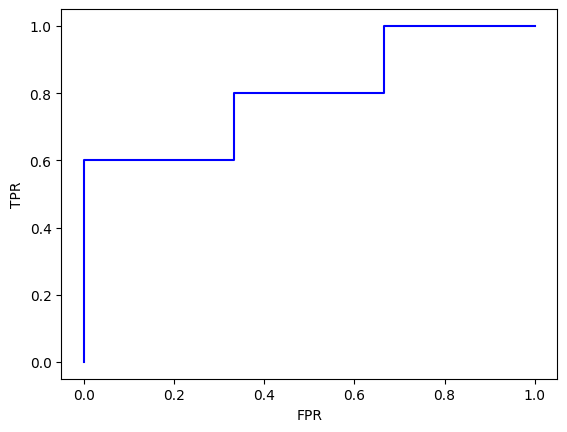

In [36]:
import matplotlib.pyplot as pyplot

# Transform it into something more handy
fpr = summary.roc.select('FPR').rdd.map(lambda r: r[0]).collect()
tpr = summary.roc.select('TPR').rdd.map(lambda r: r[0]).collect()

pyplot.plot(fpr, tpr, 'b-')
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

We do not have too many points to draw so our ROC curve looks so steeped.



# Kmeans Clustering

MLlib offers an implementation of KMeans with centroids initialization using [KMeans++]
(https://en.wikipedia.org/wiki/K-means%2B%2B) ([docs](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.clustering.KMeans.html?highlight=kmeans#pyspark.ml.clustering.KMeans))

The following example runs KMeans with $k=2$

In [38]:
'''
echo "
x,y
0,0
0,2
2,0
1,0
0,1
0.3,0.87
1,-1.3
0.9,-1.2" > /tmp/kmeans_example.csv
'''

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

# Create the dataset
observations = [[Vectors.dense([0,0])],
                [Vectors.dense([0,2])],
                [Vectors.dense([2,0])],
                [Vectors.dense([1,0])],
                [Vectors.dense([0,1])],
                [Vectors.dense([0.3,0.87])],
                [Vectors.dense([1,-1.3])],
                [Vectors.dense([0.9,-1.2])]
               ]

dataset = session.createDataFrame(observations, ['features'])
dataset.show()

# Configure and fit the model
kmeans = KMeans(k=2)
model = kmeans.fit(dataset)

+----------+
|  features|
+----------+
| [0.0,0.0]|
| [0.0,2.0]|
| [2.0,0.0]|
| [1.0,0.0]|
| [0.0,1.0]|
|[0.3,0.87]|
|[1.0,-1.3]|
|[0.9,-1.2]|
+----------+



Once the model is fit, we can take a look at the predicted clusters and the generated centroids.

In [39]:
print("Centroids %s" % model.clusterCenters())

Centroids [array([0.45714286, 0.19571429]), array([2., 0.])]


In [40]:
model.summary.predictions.show()

+----------+----------+
|  features|prediction|
+----------+----------+
| [0.0,0.0]|         0|
| [0.0,2.0]|         0|
| [2.0,0.0]|         1|
| [1.0,0.0]|         0|
| [0.0,1.0]|         0|
|[0.3,0.87]|         0|
|[1.0,-1.3]|         0|
|[0.9,-1.2]|         0|
+----------+----------+



For a more visual analysis, we can plot the centroids and the reference circle. There is not too much data for a good clustering. However, the centroids are located inside and outside the circle which in a first attempt looks promising. Obviously the data distribution is a bit biased and forces one of the centroids to the bottom right. How the algorithm would evolve with a more uniformly distributed dataset remains as an additional exercise.

Observe that we need some workaround to get the correct `numpy` shape for our plot.

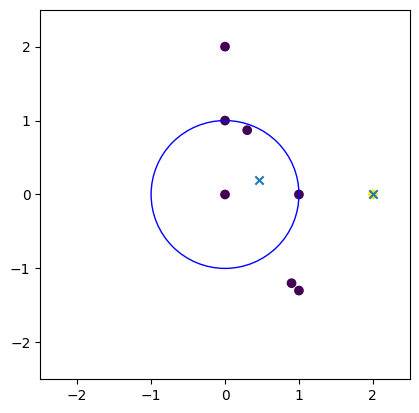

In [41]:
import matplotlib.pyplot as pyplot
import numpy as np

# Transform it into something more handy
features = model.summary.predictions.select('features').rdd.map(lambda r: r[0]).collect()
predictions = model.summary.predictions.select('prediction').rdd.map(lambda r: r[0]).collect()

x,y = np.array(features)[:,0], np.array(features)[:,1]

ax = pyplot.gca()
ax.cla()

# Plot the predictions
ax.scatter(x,y,c=predictions)

# Plot the centroids
centroids = np.array(model.clusterCenters())
ax.scatter(x=centroids[:,0], y=centroids[:,1], marker='x')

# Plot the circle as a reference
circle = pyplot.Circle((0,0),1, color='blue', fill=False)
ax.add_patch(circle)

ax.set_xlim((-2.5,2.5))
ax.set_ylim((-2.5,2.5))

# Make a square plot for a better visualization of the circle
ax.set_aspect('equal', adjustable='box')

pyplot.show()

session.stop()

# Topic Modelling

The Latent Dirichlet Allocation (LDA) (do not confuse with Linear Discriminant Analysis) is a method for topic modelling. This method can be used to extract the topics contained in a corpus. For example: extract the topics from a collection of users' opinions, main ideas discussed in wiki-leaks, etc.

LDA represents documents as a mixture that spit out words with certain probabilities. The final model is solved using bayesian inference.

$$
P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\theta}, \boldsymbol{\varphi};\alpha,\beta) = \prod_{i=1}^K P(\varphi_i;\beta) \prod_{j=1}^M P(\theta_j;\alpha) \prod_{t=1}^N P(Z_{j,t}\mid\theta_j)P(W_{j,t}\mid\varphi_{Z_{j,t}})
$$

where
- $\alpha$ is the parameter of the Dirichlet prior on the per-document topic distributions
- $\beta$ is the parameter of the Dirichlet prior on the per-topic word distribution
- $\theta_{m}$ is the topic distribution for document m
- $\varphi_{k}$ is the word distribution for topic k
- $z_{mn}$ is the topic for the n-th word in document m
- $w_{mn}$ is the specified word

In pseudocode the algorithm can be described as follows [[Blei et al.](http://ai.stanford.edu/~ang/papers/jair03-lda.pdf)]:

    Assign randomly each word in every document a topic
    for number of iterations do
        for every word w in document d do
            for each topic t ∈ K do
                Compute the proportion of words in d assigned to t
                Compute the proportion of assignments to t that come from w
                Reassign a new topic using p(t|d) · p(w|t)
            end for
        end for
    end for

After a certain number of iterations, LDA reaches a steady state with a mixture of topics per document. Every document belongs to the $K$ topics with a certain probability. A plausible example could be as follows:

| Document | Probability topic 1 | Probability topic 2 |
|----------|---------------------|---------------------|
|I like apples | 1 | 0 |
|I eat apples | 0  | 1 |
|There is no white apples | 0.8 | 0.2 |
|I don't eat apples | 0.3 | 0.7 |

Spark MLlib offers and LDA implementation using:
- EMLDAOptimizer: batch approach
- OnlineLDAOptimizer: incremental learning solution

The fitted model offers a description of the $K$ topics and the transformer computes the probability of every document to belong to every topic as described above ([ref](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.ml.clustering.LDA.html?highlight=lda#lda)).

In [45]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import IDF, Tokenizer, CountVectorizer

session = SparkSession.builder.appName("Example").master("local").getOrCreate()

corpus = session.createDataFrame ([
                                (0.0, 'Java has been around for a while'),
                                (0.0, 'I wish Java could use case classes'),
                                (0.0, 'Objects belong to classes in Java'),
                                ], ['label', 'sentence'])

# First, get the tokens
tokenizer = Tokenizer(inputCol ='sentence', outputCol ='tokens')
tokens = tokenizer.transform(corpus)
tokens.show(truncate=False)


# Second, compute the frequency of every token. We could remove stop words here.
# We are going to reduce the corpus to a vocabulary of two words for those tokens appearing at least twice in the corpus.
vectorizer = CountVectorizer(inputCol='tokens', outputCol='frequencies', minDF=2.0, vocabSize=2)
model = vectorizer.fit(tokens)
print("This is our vocabulary %s" % model.vocabulary)
frequencies = model.transform(tokens)
frequencies.show()



+-----+----------------------------------+------------------------------------------+
|label|sentence                          |tokens                                    |
+-----+----------------------------------+------------------------------------------+
|0.0  |Java has been around for a while  |[java, has, been, around, for, a, while]  |
|0.0  |I wish Java could use case classes|[i, wish, java, could, use, case, classes]|
|0.0  |Objects belong to classes in Java |[objects, belong, to, classes, in, java]  |
+-----+----------------------------------+------------------------------------------+

This is our vocabulary ['java', 'classes']
+-----+--------------------+--------------------+-------------------+
|label|            sentence|              tokens|        frequencies|
+-----+--------------------+--------------------+-------------------+
|  0.0|Java has been aro...|[java, has, been,...|      (2,[0],[1.0])|
|  0.0|I wish Java could...|[i, wish, java, c...|(2,[0,1],[1.0,1.0])|
|  0

In [46]:
from pyspark.ml.clustering import LDA
lda = LDA(k=2, maxIter = 10, featuresCol='frequencies', optimizer='em')
lda_model = lda.fit(frequencies)

topics = lda_model.describeTopics(3)
topics.show(truncate=False)

session.stop()

+-----+-----------+----------------------------------------+
|topic|termIndices|termWeights                             |
+-----+-----------+----------------------------------------+
|0    |[0, 1]     |[0.591822231531493, 0.40817776846850695]|
|1    |[0, 1]     |[0.6081744624264148, 0.3918255375735851]|
+-----+-----------+----------------------------------------+



# Evaluation

In order to understand the correctness of a model we need to compute its associated prediction error. First, we have to understand that during the training phase (fitting) our model should not use observations used during the evaluation phase. In this way, we check if our model can really make predictions on an observation never seen before and avoid potential overfitting. To do so, we have to differentiate between training and test datasets.

For the evaluation, MLlib offers a collection of evaluators. Depending on the prediction problem we are working on, we have to select the corresponding error evaluator which usually supports a variety of metrics.


## Random split

A simple way to obtain is using the `randomSplit` method from the data frame objects. We simply indicate the ratio from the total of rows dedicated to the train and evaluation and we get both 

In [47]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

dataset = session.createDataFrame([
    (0, "I think I saw something"),
    (1, "PySpark is awesome"),
    (2, "Python = data powers"),
    (3, "You don't need scala to use Spark"),
    (4, "Programming is an art"),
], ['id', 'doc'])

dataset.show()

train_ratio = 0.6
eval_ratio = 0.4

train, eval = dataset.randomSplit([train_ratio, eval_ratio])
print('Our training dataset')
train.show(truncate=False)
print('Our evaluation dataset')
eval.show(truncate=False)

session.stop()

+---+--------------------+
| id|                 doc|
+---+--------------------+
|  0|I think I saw som...|
|  1|  PySpark is awesome|
|  2|Python = data powers|
|  3|You don't need sc...|
|  4|Programming is an...|
+---+--------------------+

Our training dataset
+---+-----------------------+
|id |doc                    |
+---+-----------------------+
|0  |I think I saw something|
|2  |Python = data powers   |
|4  |Programming is an art  |
+---+-----------------------+

Our evaluation dataset
+---+---------------------------------+
|id |doc                              |
+---+---------------------------------+
|1  |PySpark is awesome               |
|3  |You don't need scala to use Spark|
+---+---------------------------------+



## Binary classification

The `BinaryClassificationEvaluator` expects a column with the labels and one with the predictions. The predictions can be represented in two ways:
- Type double. Where we represent binary values 0/1 or the probability of having label 1.
- Length 2 vector. Raw predictions, scores, or label probabilities.

Two different metrics can be selected with the `metricName` param: `areaUnderPR` or `areaUnderROC`. Check the [docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.BinaryClassificationMetrics.html?highlight=areaunderpr#binaryclassificationmetrics) for more details.

In [48]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

label_preds = session.createDataFrame([
    (1.0, 0.35),
    (1.0, 0.9),
    (1.0, 0.18),
    (0.0, 1.0),
],['label', 'prediction'])

label_preds.show()

bce = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderPR')
bce.evaluate(label_preds)

session.stop()


[Stage 0:>                                                          (0 + 1) / 1]



+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|      0.35|
|  1.0|       0.9|
|  1.0|      0.18|
|  0.0|       1.0|
+-----+----------+



## Regression 

Evaluator for regression models. The following metrics can be specified in the `metricName` param:
- rmse: root mean squared error (default)
- mse: mean squared error
- r2: $r^2$ metric
- mae: mean absolute error
- var: explained variance

In [49]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator

session = SparkSession.builder.appName('Example').master('local').getOrCreate()

label_preds = session.createDataFrame([
    (15.0, 11.0),
    (5.32, 6.0),
    (1.40, 3.8),
    (5.0, 1.8),
],['label', 'prediction'])

label_preds.show()

# We compute the mean absolute error (MAE)
re = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
re.evaluate(label_preds)

session.stop()


[Stage 0:>                                                          (0 + 1) / 1]



+-----+----------+
|label|prediction|
+-----+----------+
| 15.0|      11.0|
| 5.32|       6.0|
|  1.4|       3.8|
|  5.0|       1.8|
+-----+----------+



## Cross-validation

Cross validation splits the dataset into $k$ folds and uses $k-1$ folds for training and one fold for evaluation. This operaiton is done $k$ times ensuring variability during the process.

Assuming $k=4$ we split a dataset $D$ into $\{D_0,D_1,D_2,D_3\}$ generating the training-evaluation pairs as shown below.

| Training | Evaluation |
|:----------:|------------:|
| $$\{D_1,D_2,D_3\}$$ | $\{D_0\}$ |
| $$\{D_0,D_2,D_3\}$$ | $\{D_1\}$ |
| $$\{D_0,D_1,D_3\}$$ | $\{D_2\}$ |
| $$\{D_0,D_1,D_2\}$$ | $\{D_3\}$ |



The cross validation has several advantages:
- It is [embarrasingly parallel](https://en.wikipedia.org/wiki/Embarrasissingly_parallel)
- The quality of a model is the average of its evaluation over the different evaluatio sets
- Userful approach to the hyperparameter problem

And some disadvantages:
- It can be very expensive with large datasets
- Transformations using information extracted from the whole dataset instead of the training folds may lead to biased results

In MLlib we simply have to configure a `CrossValidator` indicating the estimator, the evaluator, the params (if any) and the number of folds.

```python
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(estimator=pipeline, evaluator=BinaryClassificationEvaluator(), estimatorParamMaps=paramGrid, numFolds=10)
```

The `CrossValidator` will use the evaluator to identify the best model. Then, it can be used as usual

```python
cv_model = cv.fit(dataset)
cv_model.transform(testDataset)
```

The `ParamGridBuilder` permits to create a grid for the search of hyperparameters that can be later used in the cross validation.

```python
from pyspark.ml.tuning import ParamGridBuilder

grid = ParamGridBuilder()
grid.addGrid(param=lm.elasticNetParam, values=[0.1,0.3])
grid.build()
```